# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**: Priya Shah, Bailey Belinger, Camila Monter

**ID**:

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/bee4750/hw/hw3-last-three-braincells`


In [3]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

3.755999600467006

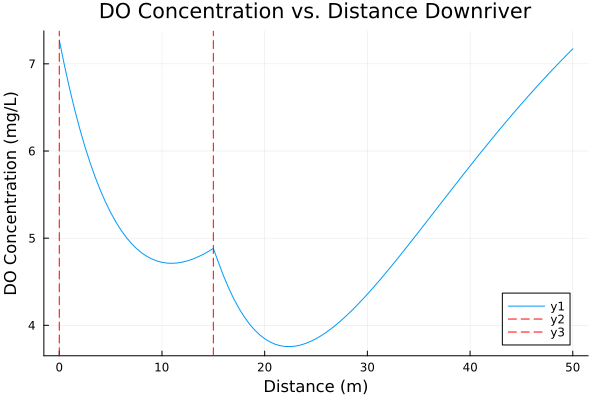

In [4]:
function mix(Q0,C0,N0,B0,Q1,C1,N1,B1)
    Qout=Q0+Q1 
    Cout=((Q0*C0)+(Q1*C1))/Qout
    Nout=((Q0*N0)+(Q1*N1))/Qout
    Bout=((Q0*B0)+(Q1*B1))/Qout
    return(Qout,Cout,Nout,Bout)
end

function do_simulate(x, C0, B0, N0, ka, kn, kc, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    a1 = exp(-ka * x / U)
    a2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    a3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - a1) + (C0 * a1) - (B0 * a2) - (N0 * a3)
    return (C, B, N)
end  

function DO_w_discharge(ka, kc, kn, C0, B0, N0, Q0, C1, B1, N1, Q1, C2, B2, N2, Q2, Cs, U, d, dist_bet)
    x_values = collect(0:0.5:d)
    num = 1
    DO_output = zeros(d*2+1)
    for x = 0:0.5:d
        # Initial mixing
        QA,CA,NA,BA = mix(Q0,C0,N0,B0,Q1,C1,N1,B1)
        if x <= dist_bet
         C, B, N = do_simulate(x, CA, BA, NA, ka, kn, kc, Cs, U)
         DO_output[num] = C
     
        else 
         C15, B15, N15 = do_simulate(dist_bet, CA, BA, NA, ka, kn, kc, Cs, U)
         QB,CB,NB,BB = mix(QA,C15,N15,B15,Q2,C2,N2,B2)
         C, B, N = do_simulate(x-dist_bet, CB, BB, NB, ka, kn, kc, Cs, U)
         DO_output[num] = C
        end
        num = num + 1
     end
     return(DO_output, x_values)
end

# set river properties
ka = 0.55
kc = 0.35
kn = 0.25

C0 = 7.5 #mg/L
B0 = 5 #mg/L
N0 = 5 #mg/L
Q0 = 100000 #m^3/day

C1= 5 #mg/L
B1 = 50 #mg/L
N1 = 35 #mg/L
Q1 = 10000 #m^3/day

C2= 5 #mg/L
B2 = 45 #mg/L
N2 = 35 #mg/L
Q2 = 15000 #m^3/day

Cs = 10 #mg/L
U = 6 #km/day

dist_bet = 15
d = 50

DO_output, x_values = DO_w_discharge(ka, kc, kn, C0, B0, N0, Q0, C1, B1, N1, Q1, C2, B2, N2, Q2, Cs, U, d, dist_bet)

#display(DO_output)

# Determine minimum of DO concentration
min_DO = minimum(DO_output)
display(min_DO)

plot(x_values, DO_output, xlabel = "Distance (m)", ylabel = "DO Concentration (mg/L)", title = "DO Concentration vs. Distance Downriver")
# Add a vertical line at first waste discharge
vline!([dist_bet], linestyle=:dash, color=:red) 
vline!([0], linestyle=:dash, color=:red) 


Comment on minimum DO value

In [5]:
# Waste stream 1 treated
p_removal = 0
min_DO1 = min_DO
while min_DO1 <= 4
    p_removal = p_removal + 0.00001
    B1 = B1 - (B1*p_removal)
    N1 = N1 - (N1*p_removal)
    DO_output, x_values = DO_w_discharge(ka, kc, kn, C0, B0, N0, Q0, C1, B1, N1, Q1, C2, B2, N2, Q2, Cs, U, d, dist_bet)
    min_DO1 = minimum(DO_output)
end
display(min_DO1)
display(p_removal*100)

4.000808873092684

0.1810000000000004

In [6]:
# Waste stream 2 treated
B1 = 50 #mg/L
N1 = 35 #mg/L
p_removal = 0
min_DO2 = min_DO
while min_DO2 <= 4
    p_removal = p_removal + 0.00001
    B2 = B2 - (B2*p_removal)
    N2 = N2 - (N2*p_removal)
    DO_output, x_values = DO_w_discharge(ka, kc, kn, C0, B0, N0, Q0, C1, B1, N1, Q1, C2, B2, N2, Q2, Cs, U, d, dist_bet)
    min_DO2 = minimum(DO_output)
end
display(min_DO2)
display(p_removal*100)


4.000162567236884

0.15700000000000033

Comment on percentages

In [7]:
# Both waste streams treated equally
B1 = 50 #mg/L
N1 = 35 #mg/L
B2 = 45 #mg/L
N2 = 35 #mg/L
p_removal = 0
while min_DO <= 4
    p_removal = p_removal + 0.00001
    B1 = B1 - (B1*p_removal)
    N1 = N1 - (N1*p_removal)
    B2 = B2 - (B2*p_removal)
    N2 = N2 - (N2*p_removal)
    DO_output, x_values = DO_w_discharge(ka, kc, kn, C0, B0, N0, Q0, C1, B1, N1, Q1, C2, B2, N2, Q2, Cs, U, d, dist_bet)
    min_DO = minimum(DO_output)
end
display(min_DO)
display(p_removal*100)

4.000979363006898

0.11600000000000024

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [8]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

751-element Vector{Float64}:
  0.25918289716993287
  0.24176756635599128
  0.21325975144045076
  0.17850291224529793
  0.1457411149414377
  0.09840432796857469
 -0.13383410588305977
  0.01724897551757567
  0.14777213389926366
  0.22712653379357609
  0.2624881820283316
  0.2610752608567423
 -0.6636468288148648
  ⋮
 12.644957915496068
 12.642990730156399
 12.640949277624589
 12.638871538651715
 12.636828023749903
 12.634811388909599
 12.632786007467395
 12.630739504290775
 12.628694395288093
 12.626673788131408
 12.624680005793559
 12.623637075242984

We can plot the aerosol and non-aerosol forcings below.

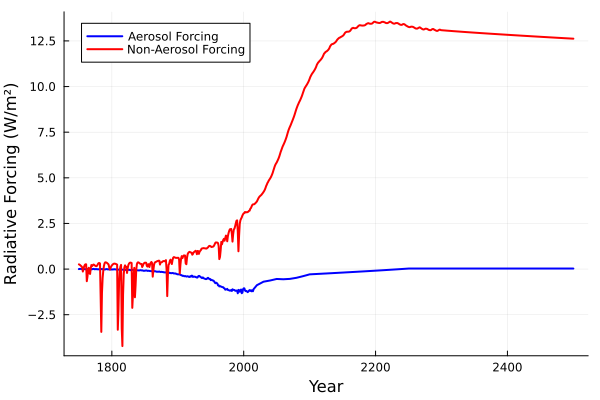

In [9]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

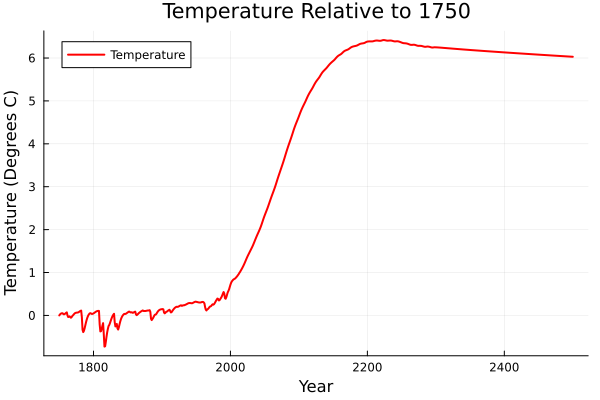

In [10]:
lambda = 2.1 #degrees C / (W/m^2)
c = 4.184e6 #Joules/Kelvin*m^2
d = 86 #meters
a = 0.8 # uncertainty scaling factor
C = c * d
delta_t = 31558152 #seconds


function simulate_T(forcing_total, delta_t, lambda, C)
    T_vec = zeros(length(forcing_total))
    for i = 2:length(forcing_total)
        F = forcing_total[i]
        T_vec[i] = T_vec[i-1] + (delta_t/C)*(F-lambda*T_vec[i-1])
    end
    return(T_vec)
end

T_vec = simulate_T(forcing_total, delta_t, lambda, C)

plot(t, T_vec, label="Temperature", xlabel = "Year", ylabel = "Temperature (Degrees C)", title = "Temperature Relative to 1750" , color=:red, linewidth=2)

**ask about shape of graph in terms of impact of negative forcings**

In [16]:
function MC_simulate_T(F, delta_t, C, n, t)
    T_vec = zeros(length(t))
    T_2100 = zeros(n)
    lambda_dist = LogNormal(log(2.1),(log(2)/4))
    for k = 1:n
        lambda_sample = rand(lambda_dist)
        for i = 2:length(t)
            T_vec[i] = T_vec[i-1] + (delta_t/C)*(F-lambda_sample*T_vec[i-1])
        end
        T_2100[k] = T_vec[2100-1750]
    end
    return(T_2100)
end

F = 8.5 #radiative forcings
n = 10_000 

T_2100 = MC_simulate_T(F, delta_t, C, n, t)

T_run_est = cumsum(T_2100)./(1:n)
n_vec = collect(1:n)
display(length(T_run_est))
display(length(n))

plot(n, T_run_est, label="Temperature", xlabel = "Year", ylabel = "Temperature (Degrees C)", title = "Temperature Relative to 1750" , color=:red, linewidth=2)

10000

1

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

**In this problem**:

-   Assume that the treatment plan you identified in Problem 1 is still
    in place for the existing discharges. If the third discharge will
    not be treated, under the original inflow conditions (7.5 mg/L DO),
    how far downstream from the second discharge does this third
    discharge need to be placed to keep the river concentration from
    dropping below 4 mg/L?

## References

List any external references consulted, including classmates.